In [21]:
!pip install kagglehub

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
import kagglehub

path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'animals-detection-images-dataset' dataset.
Path to dataset files: /kaggle/input/animals-detection-images-dataset


In [23]:
IMG_SIZE = 160      # ↓ from 224
BATCH_SIZE = 24     # balanced for speed + GPU memory

data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = data_gen.flow_from_directory(
    path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = data_gen.flow_from_directory(
    path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 23257 images belonging to 2 classes.
Found 5814 images belonging to 2 classes.


In [24]:
# MobileNetV2
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    alpha=0.35,                 # 🔥 much faster
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        432 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40, 8) │        384 │ block_1_depthwis

 Total params: 412,770 (1.57 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 410,208 (1.56 MB)

In [25]:
EPOCHS = 4

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
970/970 ━━━━━━━━━━━━━━━━━━━━ 559s 569ms/step - accuracy: 0.7622 - loss: 0.5440 - val_accuracy: 0.7153 - val_loss: 0.5559
Epoch 2/4
970/970 ━━━━━━━━━━━━━━━━━━━━ 486s 501ms/step - accuracy: 0.7805 - loss: 0.4927 - val_accuracy: 0.7494 - val_loss: 0.5188
Epoch 3/4
970/970 ━━━━━━━━━━━━━━━━━━━━ 467s 481ms/step - accuracy: 0.7902 - loss: 0.4703 - val_accuracy: 0.7286 - val_loss: 0.5446


In [52]:
from tensorflow.keras.preprocessing import image

class_names = list(train_data.class_indices.keys())

species_descriptions = {
    "Bear": (
        "Bears are large omnivorous mammals found in forests, mountains, and tundra regions. "
        "They have strong limbs, sharp claws, and an excellent sense of smell, which helps them "
        "locate food such as fruits, insects, fish, and small animals. Bears play an important role "
        "in maintaining ecological balance by controlling prey populations and dispersing seeds."
    ),

    "Bird": (
        "Birds are warm-blooded vertebrates characterized by feathers, wings, and beaks. "
        "Most bird species can fly, while others are adapted for running or swimming. "
        "They are vital to ecosystems as pollinators, seed dispersers, and natural pest controllers."
    ),

    "Cat": (
        "Cats are small carnivorous mammals known for their agility, sharp claws, and keen senses. "
        "They are skilled hunters with excellent night vision and quick reflexes. "
        "Both wild and domestic cats play a role in controlling rodent populations."
    ),

    "Cow": (
        "Cows are large domesticated herbivores commonly raised for milk, meat, and leather. "
        "They have a complex digestive system that allows them to break down tough plant material. "
        "Cows are generally calm animals and are an important part of agricultural ecosystems."
    ),

    "Deer": (
        "Deer are graceful herbivorous mammals commonly found in forests, grasslands, and wetlands. "
        "Many male deer grow antlers annually, which are used for defense and mating displays. "
        "Deer are highly alert animals and serve as an important prey species in many ecosystems."
    ),

    "Dog": (
        "Dogs are domesticated mammals known for their intelligence, loyalty, and strong social bonds "
        "with humans. They have highly developed senses of smell and hearing, making them useful for "
        "search, rescue, and conservation work. Dogs have been companions to humans for thousands of years."
    ),

    "Elephant": (
        "Elephants are the largest land mammals and are known for their intelligence, memory, and social behavior. "
        "They use their trunks for feeding, drinking, communication, and tool use. "
        "Elephants play a crucial ecological role by shaping landscapes and creating pathways for other species."
    ),

    "Horse": (
        "Horses are strong, fast herbivorous mammals that have been domesticated for transportation, farming, "
        "and sports. They are highly social animals with excellent endurance and awareness of their surroundings. "
        "Historically, horses have played a major role in human civilization and development."
    ),

    "Lion": (
        "Lions are large carnivorous mammals often referred to as the kings of the jungle. "
        "They are unique among big cats for living in social groups called prides. "
        "Lions play a key role as apex predators, helping regulate prey populations in their habitats."
    ),

    "Tiger": (
        "Tigers are powerful and solitary big cats recognized by their distinctive striped fur. "
        "They are excellent hunters with strong muscles, sharp teeth, and stealthy movement. "
        "Tigers are apex predators and are considered an important indicator species for healthy ecosystems."
    ),

    "Monkey": (
    "Monkeys are intelligent and social mammals commonly found in forests, grasslands, and mountainous regions. "
    "They are known for their agility, strong limbs, and problem-solving abilities. "
    "Monkeys play an important role in ecosystems by dispersing seeds and maintaining forest biodiversity."
),

"Butterfly": (
    "Butterflies are colorful insects known for their delicate wings and graceful flight. "
    "They undergo complete metamorphosis, transitioning from caterpillar to adult butterfly. "
    "Butterflies play a vital ecological role as pollinators and are often indicators of a healthy environment."
),

    "Goose": (
    "Geese are large water birds commonly found near lakes, rivers, and wetlands. "
    "They are known for their long necks, strong wings, and loud honking calls. "
    "Geese often live and travel in groups and play an important role in wetland ecosystems."
),
    "Duck": (
    "Ducks are water birds commonly found near ponds, lakes, and rivers. "
    "They have webbed feet that help them swim and flat bills used for feeding. "
    "Ducks play an important role in aquatic ecosystems by controlling insects and spreading plant seeds."
)

}

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    idx = np.argmax(preds)
    species = class_names[idx]

    print(f"Predicted Species: {species}")
    print(f"Description: {species_descriptions[species]}")

    plt.imshow(img)
    plt.axis("off")

Saving wildlife test 5.avif to wildlife test 5 (2).avif
Uploaded image: wildlife test 5 (2).avif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
🐾 Predicted Animal: Monkey
📊 Confidence: 0.64
📖 Description: Monkeys are intelligent and social mammals commonly found in forests, grasslands, and mountainous regions. They are known for their agility, strong limbs, and problem-solving abilities. Monkeys play an important role in ecosystems by dispersing seeds and maintaining forest biodiversity.


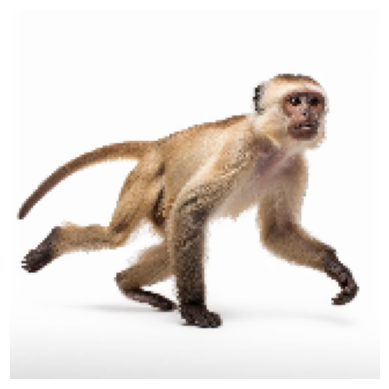

In [54]:
from google.colab import files

uploaded = files.upload()

# Get uploaded file name
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)
predict_uploaded_image(image_path)